In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval
import numpy as np
import matplotlib.pyplot as plt
from seisLM.utils import project_path
from phasepick_model_registry import ckpt_registry

In [2]:
from ml_collections import config_dict
training_fracs = ['0.05', '0.1', '0.2', '0.5', '1.0']
eval_set = 'test'
data_name = 'ETHZ'
assert data_name in ckpt_registry.keys()

In [3]:
# train_frac = '0.05'
# ckpt_paths = ckpt_registry[data_name]['EQTransformer']
# model_identifier = ckpt_paths[train_frac].split('/')[-3]

# print(model_identifier)

# base_pred_path = (
#   Path(project_path.EVAL_SAVE_DIR)
#   / f"{model_identifier}_{data_name}"
# )

# print(base_pred_path)

# event_detection_result = pick_eval.get_results_event_detection(
#   base_pred_path / f"{eval_set}_task1.csv")

# phase_identification_result = pick_eval.get_results_phase_identification(
#   base_pred_path / f"{eval_set}_task23.csv"
# )

# onset_determination_result = pick_eval.get_results_onset_determination(
#   base_pred_path / f"{eval_set}_task23.csv"
# )


In [4]:

all_training_frac_results = {}

for train_frac in training_fracs:
  model_result = {}

  for model_name, ckpt_paths in ckpt_registry[data_name].items():

    model_identifier = ckpt_paths[train_frac].split('/')[-3]

    base_pred_path = (
      Path(project_path.EVAL_SAVE_DIR)
      / f"{model_identifier}_{data_name}"
    )

    event_detection_result = pick_eval.get_results_event_detection(
      base_pred_path / f"{eval_set}_task1.csv")

    phase_identification_result = pick_eval.get_results_phase_identification(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    onset_determination_result = pick_eval.get_results_onset_determination(
      base_pred_path / f"{eval_set}_task23.csv"
    )

    model_result[model_name] = {
      'event_detection': event_detection_result,
      'phase_identification': phase_identification_result,
      'onset_determination': onset_determination_result
    }

  all_training_frac_results[train_frac] = model_result

/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/evaluation/pick_eval.py:179: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * recall / (prec + recall)


In [5]:
phasenet_kwargs = {
  'color': '#fc8d59',
  'linestyle': '--',
  'lw': 2,
}

eqtransformer_kwargs = {
  'color': '#91bfdb',
  'linestyle': '-',
  'lw': 2,
}

# seislm_kwargs = {
#   'label': 'SeisLM',
#   'color': '#1b7837',
#   'linestyle': '-',
#   'lw': 2,
# }


model_kwargs = {}
model_kwargs['PhaseNet'] = phasenet_kwargs
model_kwargs['EQTransformer'] = eqtransformer_kwargs

## Task 1

PhaseNet
EQTransformer


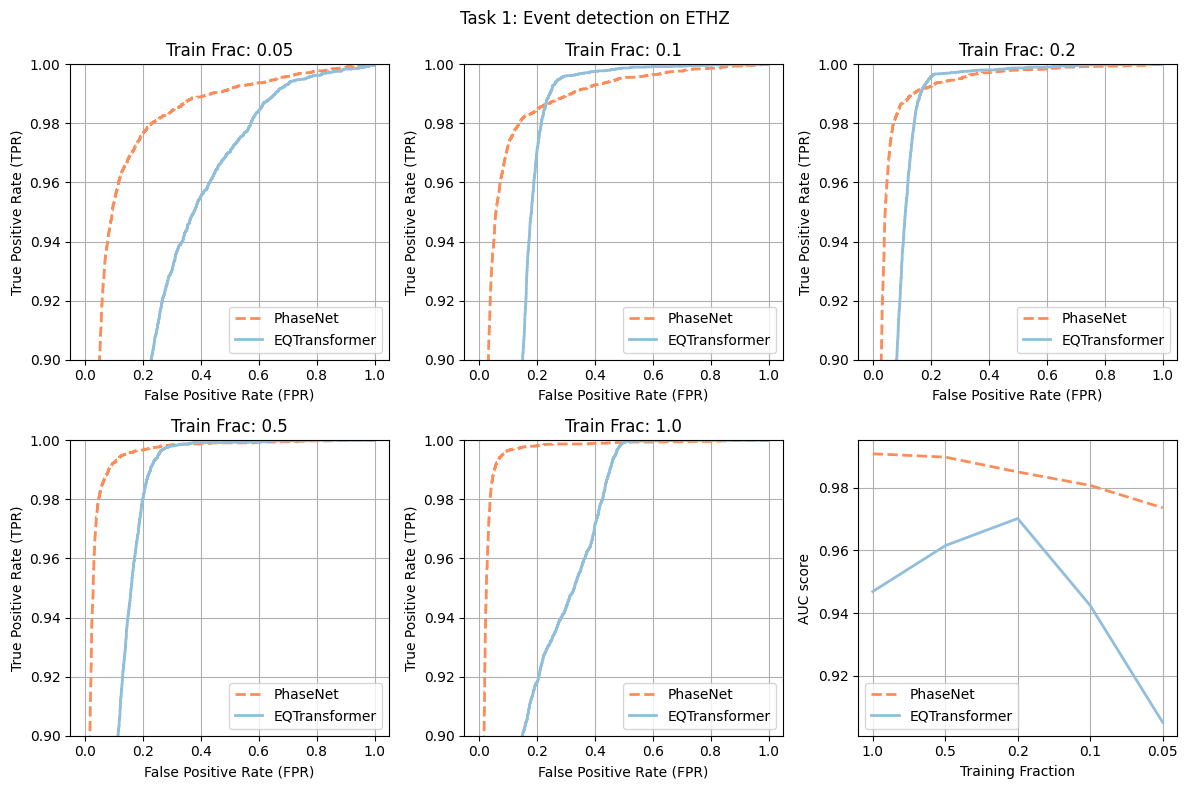

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

i = 0
for train_frac, result_of_models in all_training_frac_results.items():
    ax = axes[i]
    for model_name, model_result in result_of_models.items():
      line, = ax.plot(
        model_result['event_detection']['fpr'],
        model_result['event_detection']['tpr'],
        label=model_name,
        ** model_kwargs[model_name]
      )

    ax.set_ylim([0.9, 1])
    ax.set_title(f'Train Frac: {train_frac}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)
    ax.legend(loc='lower right')
    # Capture the handles and labels for the legend
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()
    i += 1


for model_name in all_training_frac_results[training_fracs[0]].keys():
  print(model_name)
  axes[-1].plot(
    training_fracs[::-1],
    [all_training_frac_results[training_frac][model_name]['event_detection']['auc']
    for training_frac in training_fracs[::-1]],
    label=model_name,
    ** model_kwargs[model_name]
  )


axes[-1].set_xlabel("Training Fraction")
axes[-1].set_ylabel("AUC score")
axes[-1].grid()
axes[-1].legend(loc='lower left')

plt.suptitle(f'Task 1: Event detection on {data_name}')
plt.tight_layout()
plt.show()

# Task 2

PhaseNet
EQTransformer


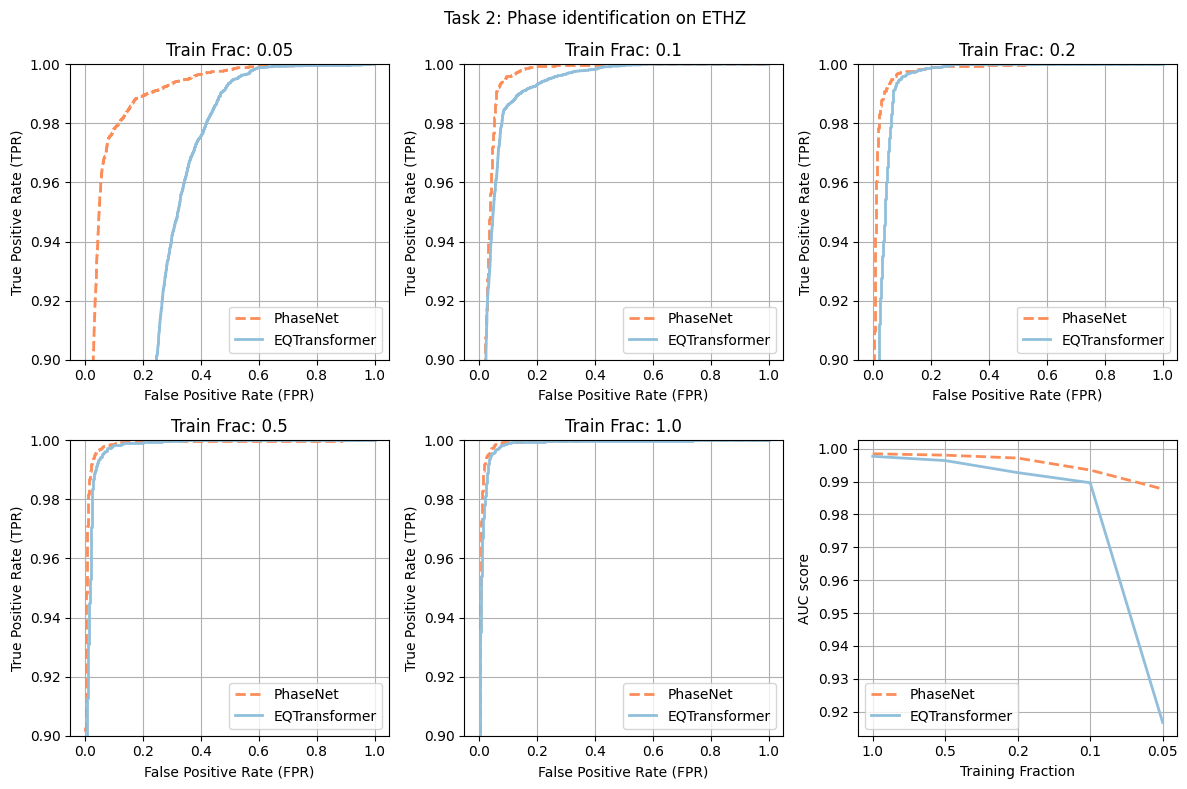

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()  # Flatten the 2x3 array of axes to easily iterate

# Initialize variables to store the handles and labels for the legend
handles, labels = None, None

i = 0
for train_frac, result_of_models in all_training_frac_results.items():
    ax = axes[i]
    for model_name, model_result in result_of_models.items():
      line, = ax.plot(
        model_result['phase_identification']['fpr'],
        model_result['phase_identification']['tpr'],
        label=model_name,
        ** model_kwargs[model_name]
      )

    ax.set_ylim([0.9, 1])
    ax.set_title(f'Train Frac: {train_frac}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)
    ax.legend(loc='lower right')
    # Capture the handles and labels for the legend
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()
    i += 1


for model_name in all_training_frac_results[training_fracs[0]].keys():
  print(model_name)
  axes[-1].plot(
    training_fracs[::-1],
    [all_training_frac_results[training_frac][model_name]['phase_identification']['auc']
    for training_frac in training_fracs[::-1]],
    label=model_name,
    ** model_kwargs[model_name]
  )


axes[-1].set_xlabel("Training Fraction")
axes[-1].set_ylabel("AUC score")
axes[-1].grid()
axes[-1].legend(loc='lower left')

plt.suptitle(f'Task 2: Phase identification on {data_name}')
plt.tight_layout()
plt.show()


# Task 3

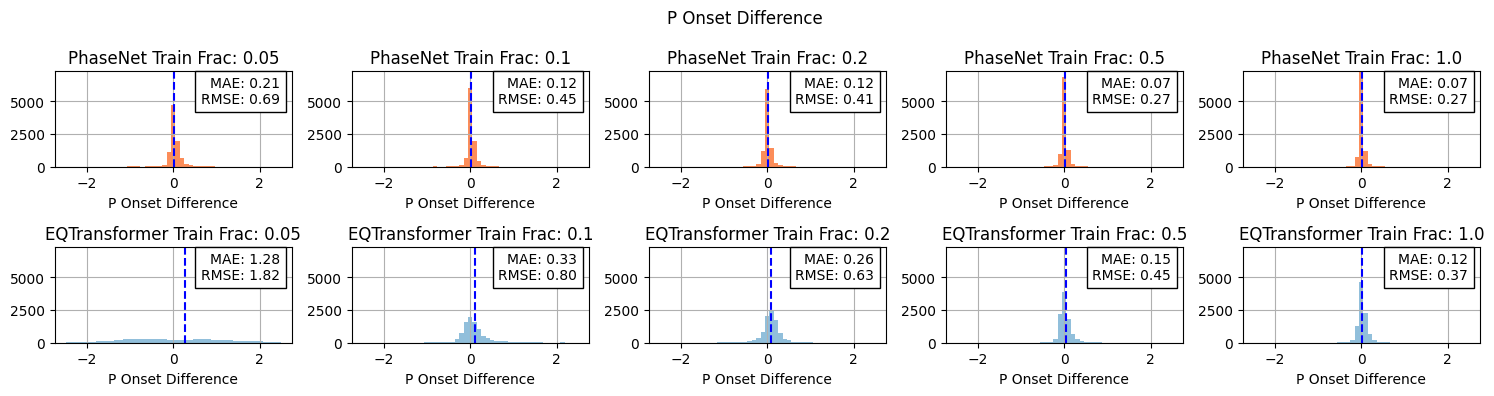

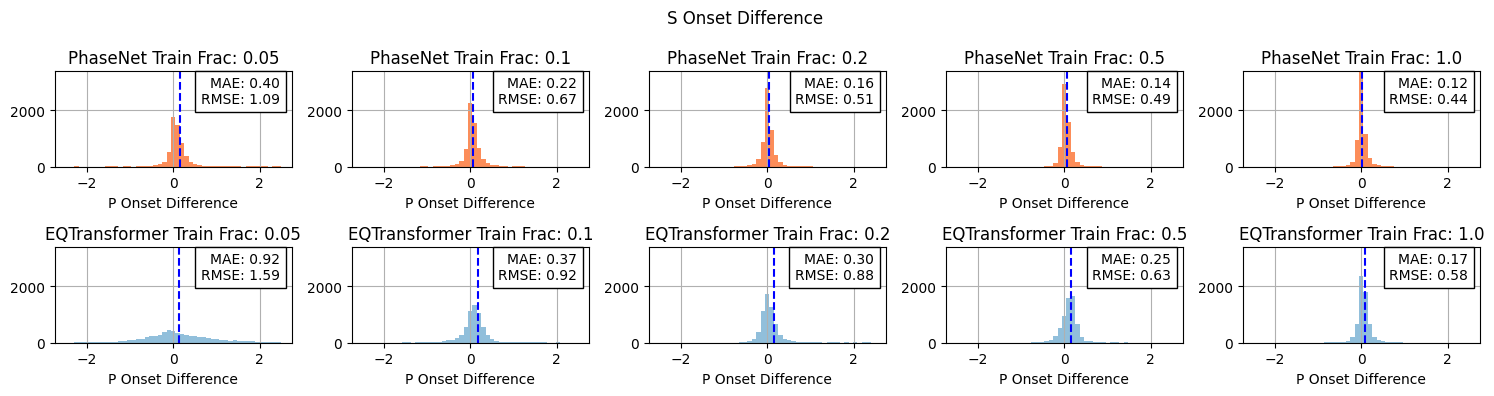

In [8]:
bins = np.linspace(-2.5, 2.5, 50)

# Create the subplots

for onset_type in ['P_onset_diff', 'S_onset_diff']:
  fig, axes = plt.subplots(2, 5, figsize=(15, 4))
  # axes = axes.ravel()  # Flatten the axes array for easier iteration

  max_y = float('-inf')
  for row_idx, (train_frac, result_of_models) in enumerate(
    all_training_frac_results.items()):
    for col_idx, (model_name, model_result) in enumerate(
      result_of_models.items()):
      ax = axes[col_idx][row_idx]

      onset_diff = model_result['onset_determination'][onset_type]
      diff_mean = np.mean(onset_diff)
      diff_rmse = np.sqrt(np.mean(onset_diff**2))
      diff_mae = np.mean(np.abs(onset_diff))

      counts, _, _ = ax.hist(onset_diff, bins, ** model_kwargs[model_name])#label='phasenet',)
      max_y = max(max_y, counts.max())

      ax.axvline(diff_mean, color='blue', linestyle='--', label='Mean')
      # axes[i].axvline(phasenet_median, color='blue', linestyle='-', label='Median')
      ax.set_title(f'{model_name} Train Frac: {train_frac}')
      ax.set_xlabel('P Onset Difference')

      # Display MSE and MAE as text inset
      ax.text(0.95, 0.95, f'MAE: {diff_mae:.2f}\nRMSE: {diff_rmse:.2f}',
                  transform=ax.transAxes, fontsize=10,
                  verticalalignment='top', horizontalalignment='right',
                  bbox=dict(facecolor='white',))
      ax.grid(True)

  for ax in axes.flatten():
      ax.set_ylim(0, max_y)


  # Adjust layout for better spacing
  onset_str = onset_type.split('_')[0]
  plt.suptitle(f'{onset_str} Onset Difference')
  plt.tight_layout()
  plt.show()
